# Load Data

In [1]:
!git clone https://github.com/emanhamed/Houses-dataset

Cloning into 'Houses-dataset'...
remote: Enumerating objects: 2166, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 2166 (delta 0), reused 0 (delta 0), pack-reused 2165
Receiving objects: 100% (2166/2166), 176.26 MiB | 9.10 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [5]:
!ls

Houses-dataset	HousesInfo.txt	sample_data


In [3]:
import os
import glob
import random
from tqdm import tqdm

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [6]:
data_path = "HousesInfo.txt"
columns = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
data = pd.read_csv(data_path, sep=" ", names=columns)
data.head()

,bedrooms,bathrooms,area,zipcode,price
0,4,4.0,4053,85255,869500
1,4,3.0,3343,36372,865200
2,3,4.0,3923,85266,889000
3,5,5.0,4022,85262,910000
4,3,4.0,4116,85266,971226


In [7]:
labels = data["price"]
labels.head()

0    869500
1    865200
2    889000
3    910000
4    971226
Name: price, dtype: int64

Houses-dataset/Houses Dataset/8_kitchen.jpg


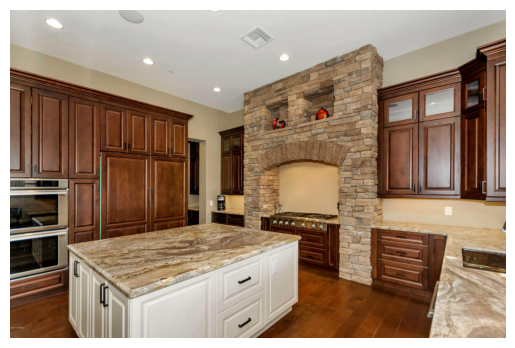

In [19]:


IMAGE_DIR = "Houses-dataset/Houses Dataset"
IMAGE_FILE_LIST = os.listdir(IMAGE_DIR)

length_image_file_list = len(IMAGE_FILE_LIST)
random_index = random.randint(0, length_image_file_list)

sample_image_dir = os.path.join(IMAGE_DIR, IMAGE_FILE_LIST[random_index])
print(sample_image_dir)

sample_image = mpimg.imread(sample_image_dir)
plt.imshow(sample_image)
plt.axis(False);

In [92]:
sorted_image_paths = []

width = 224
height = 224

dim = (width, height)


for index in tqdm(range(1, 536)):

  row_images = []

  for img_path in IMAGE_FILE_LIST:
    if img_path.startswith(f"{index}_"):
      row_images.append(img_path)

  if len(row_images) != 4:
    print(f"Skipping row {index}")
    continue



  for path in row_images:

    if path.endswith("bathroom.jpg"):
      full_path = os.path.join(IMAGE_DIR, path)
      bathroom_img = mpimg.imread(full_path)
      bathroom_img = cv2.resize(
          bathroom_img,
          dim,
          interpolation = cv2.INTER_AREA
      )


    elif path.endswith("bedroom.jpg"):
      full_path = os.path.join(IMAGE_DIR, path)
      bedroom_img = mpimg.imread(full_path)
      bedroom_img = cv2.resize(
          bedroom_img,
          dim,
          interpolation = cv2.INTER_AREA
      )


    elif path.endswith("frontal.jpg"):
      full_path = os.path.join(IMAGE_DIR, path)
      frontal_img = mpimg.imread(full_path)
      frontal_img = cv2.resize(
          frontal_img,
          dim,
          interpolation = cv2.INTER_AREA
      )


    elif path.endswith("kitchen.jpg"):
      full_path = os.path.join(IMAGE_DIR, path)
      kitchen_img = mpimg.imread(full_path)
      kitchen_img = cv2.resize(
          kitchen_img,
          dim,
          interpolation = cv2.INTER_AREA
      )


    else:
      raise ValueError("Invalid Name Convention")

  row_tuple = (frontal_img, bedroom_img, kitchen_img, bathroom_img)
  sorted_image_paths.append(row_tuple)

100%|██████████| 535/535 [00:17<00:00, 31.44it/s]


In [93]:
print(len(sorted_image_paths))

535


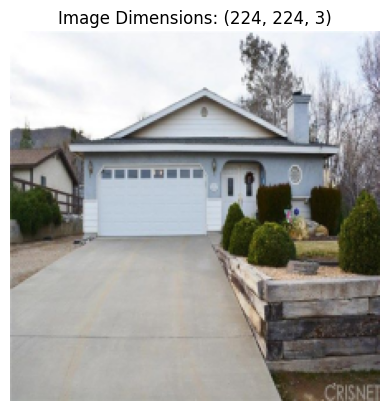

In [94]:
random_index = random.randint(0, len(sorted_image_paths))
random_image = sorted_image_paths[random_index][0]
plt.imshow(random_image)
plt.title(f"Image Dimensions: {random_image.shape}")
plt.axis(False);

In [95]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import argparse
import locale


def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)

	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)

	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)

	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)

	# check to see if the regression node should be added
	if regress:
		x = Dense(1, activation="linear")(x)

	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model

In [98]:
front_images = [row[0] for row in sorted_image_paths]
front_images_array = np.array(front_images)

print(len(front_images_array))
print(front_images_array[0].shape)

535
(224, 224, 3)


In [99]:
front_images_array = front_images_array / 255.0



In [101]:
train_features, test_features, train_labels, test_labels = train_test_split(
    front_images_array,
    labels,
    test_size = 0.2,
    random_state = 7
)

In [103]:
print(f"Train Features Shape: {train_features.shape} Train Labels Shape: {train_features.shape}")
print(f"Test Features Shape: {test_features.shape} Test Labels Shape: {test_labels.shape}")

Train Features Shape: (428, 224, 224, 3) Train Labels Shape: (428,)
Test Features Shape: (107, 224, 224, 3) Test Labels Shape: (107,)


In [106]:
max_price = train_labels.max()

train_labels = train_labels / max_price
test_labels = test_labels / max_price

In [109]:
model = create_cnn(width, height, 3, regress=True)
opt = Adam(learning_rate=1e-3)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

# train the model
print("[INFO] training model...")
history = model.fit(
    x=train_features,
    y=train_labels,
    validation_data=(test_features, test_labels),
    epochs=200,
    batch_size=10
)

[INFO] training model...
Epoch 1/200
43/43 [==============================] - 7s 41ms/step - loss: 1818.1721 - val_loss: 738.0602
Epoch 2/200
43/43 [==============================] - 1s 17ms/step - loss: 1014.8465 - val_loss: 3337.7178
Epoch 3/200
43/43 [==============================] - 1s 15ms/step - loss: 958.3478 - val_loss: 253.3743
Epoch 4/200
43/43 [==============================] - 1s 24ms/step - loss: 756.7369 - val_loss: 105.4812
Epoch 5/200
43/43 [==============================] - 1s 15ms/step - loss: 743.6088 - val_loss: 139.3348
Epoch 6/200
43/43 [==============================] - 1s 15ms/step - loss: 580.4844 - val_loss: 97.8248
Epoch 7/200
43/43 [==============================] - 1s 16ms/step - loss: 461.5342 - val_loss: 91.9145
Epoch 8/200
43/43 [==============================] - 1s 15ms/step - loss: 495.2961 - val_loss: 93.9735
Epoch 9/200
43/43 [==============================] - 1s 15ms/step - loss: 346.6645 - val_loss: 86.7941
Epoch 10/200
43/43 [====================

In [114]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

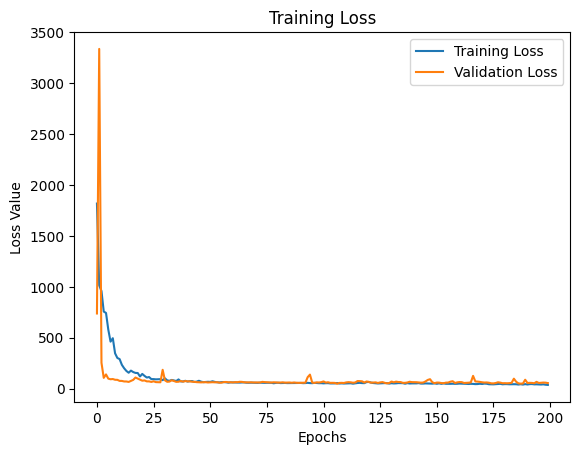

In [118]:
plt.plot(
    list(range(0, len(history.history["loss"]))),
    history.history["loss"],
    label = "Training Loss"
)
plt.plot(
    list(range(0, len(history.history["loss"]))),
    history.history["val_loss"],
    label = "Validation Loss"
)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Training Loss");

In [119]:
# make predictions on the testing data
print("[INFO] predicting house prices...")
preds = model.predict(test_features)

# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - test_labels
percentDiff = (diff / test_labels) * 100
absPercentDiff = np.abs(percentDiff)

[INFO] predicting house prices...
4/4 [==============================] - 1s 65ms/step


In [121]:
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(
	locale.currency(labels.mean(), grouping=True),
	locale.currency(labels.std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $589,362.81, std house price: $509,026.07
[INFO] mean: 54.28%, std: 35.39%
